In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
# Path to the chest-ct-segmentation dataset folder
data_dir = "dataset/Lucchi++"
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")

In [2]:
def read_image(image_path, mask_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Unable to read image file: {image_path}")
    img = img[..., ::-1]  # Convert BGR to RGB
    
    mask = cv2.imread(mask_path, 0)
    if mask is None:
        raise FileNotFoundError(f"Unable to read mask file: {mask_path}")
    
    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
    mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    return img, mask

In [3]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # 调整 g 的大小以匹配 x
        g = F.interpolate(g, size=x.size()[2:], mode='bilinear', align_corners=True)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [4]:
class AttYNet(nn.Module):
    def __init__(self, n_channels, n_classes, filters=[32, 64, 128, 256]):
        super(AttYNet, self).__init__()
        
        # Encoder (下采样路径)
        self.encoder = nn.ModuleList([
            self.conv_block(n_channels, filters[0]),
            self.conv_block(filters[0], filters[1]),
            self.conv_block(filters[1], filters[2]),
            self.conv_block(filters[2], filters[3]),
        ])
        
        # Bottleneck
        self.bottleneck = self.conv_block(filters[3], filters[3]*2)
        
        # Decoder (上采样路径)
        self.decoder = nn.ModuleList([
            self.conv_block(filters[3]*2 + filters[3], filters[3]),
            self.conv_block(filters[3] + filters[2], filters[2]),
            self.conv_block(filters[2] + filters[1], filters[1]),
            self.conv_block(filters[1] + filters[0], filters[0]),
        ])
        
        # 注意力块
        self.att_blocks = nn.ModuleList([
            AttentionBlock(filters[3]*2, filters[3], filters[2]),
            AttentionBlock(filters[3], filters[2], filters[1]),
            AttentionBlock(filters[2], filters[1], filters[0]),
            AttentionBlock(filters[1], filters[0], filters[0]//2),
        ])
        
        # 输出层
        self.output_mask = nn.Conv2d(filters[0], n_classes, kernel_size=1)
        self.output_img = nn.Conv2d(filters[0], n_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        encoder_features = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            encoder_features.append(x)
            x = F.max_pool2d(x, 2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            encoder_feature = encoder_features[-i-1]
            x = F.interpolate(x, size=encoder_feature.shape[2:], mode='bilinear', align_corners=True)
            att_feature = self.att_blocks[i](x, encoder_feature)
            x = torch.cat([x, att_feature], dim=1)
            x = decoder_layer(x)

        # Output
        mask = torch.sigmoid(self.output_mask(x))
        img = self.output_img(x)

        return img, mask

In [5]:
import torch
from torch.cuda.amp import autocast, GradScaler # 这三行是我自行添加的
import os
def load_data(data_dir, split='train'):
    images_dir = os.path.join(data_dir, f"{split.capitalize()}_In")
    masks_dir = os.path.join(data_dir, f"{split.capitalize()}_Out")
    
    data = []
    for i, image_file in enumerate(os.listdir(images_dir)):
        if image_file.endswith('.DS_Store'):
            continue
        image_path = os.path.join(images_dir, image_file)
        mask_path = os.path.join(masks_dir, f"{i}.png")
        if os.path.exists(image_path) and os.path.exists(mask_path):
            data.append({
                "image": image_path,
                "annotation": mask_path
            })
    return data

# Create datasets
train_data = load_data(data_dir, 'train')
test_data = load_data(data_dir, 'test')

class ChestCTDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        try:
            image, mask = read_image(item['image'], item['annotation'])
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
            return image, mask
        except Exception as e:
            print(f"Error loading data at index {idx}: {str(e)}")
            return None

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)
        
# Create data loaders
train_dataset = ChestCTDataset(train_data)
test_dataset = ChestCTDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [7]:
from torch.amp import autocast, GradScaler

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttYNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# 初始化 GradScaler
scaler = GradScaler()

# 梯度累积步数
accumulation_steps = 4

# 训练循环
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    torch.cuda.empty_cache()
    
    train_losses = []
    for i, data in enumerate(train_loader):
        if data is None:
            continue
        
        images, masks = data
        images, masks = images.to(device), masks.to(device)
        
        # 使用混合精度训练
        with autocast(device_type=device.type):
            _, pred_masks = model(images)
            loss = criterion(pred_masks, masks)
            loss = loss / accumulation_steps

        # 反向传播
        scaler.scale(loss).backward()
        
        train_losses.append(loss.item() * accumulation_steps)
        
        # 梯度累积
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
    
    # 计算平均训练损失
    if train_losses:
        train_loss = sum(train_losses) / len(train_losses)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], No valid batches")
        
# 保存模型
torch.save(model.state_dict(), 'attynet_model.pth')

Epoch [1/100], Train Loss: 0.8524
Epoch [2/100], Train Loss: 0.7868
Epoch [3/100], Train Loss: 0.7478
Epoch [4/100], Train Loss: 0.7228
Epoch [5/100], Train Loss: 0.7061
Epoch [6/100], Train Loss: 0.6954
Epoch [7/100], Train Loss: 0.6885
Epoch [8/100], Train Loss: 0.6839
Epoch [9/100], Train Loss: 0.6809
Epoch [10/100], Train Loss: 0.6785
Epoch [11/100], Train Loss: 0.6767
Epoch [12/100], Train Loss: 0.6754
Epoch [13/100], Train Loss: 0.6743
Epoch [14/100], Train Loss: 0.6735
Epoch [15/100], Train Loss: 0.6728
Epoch [16/100], Train Loss: 0.6722
Epoch [17/100], Train Loss: 0.6719
Epoch [18/100], Train Loss: 0.6716
Epoch [19/100], Train Loss: 0.6712
Epoch [20/100], Train Loss: 0.6708
Epoch [21/100], Train Loss: 0.6705
Epoch [22/100], Train Loss: 0.6703
Epoch [23/100], Train Loss: 0.6703
Epoch [24/100], Train Loss: 0.6702
Epoch [25/100], Train Loss: 0.6700
Epoch [26/100], Train Loss: 0.6698
Epoch [27/100], Train Loss: 0.6696
Epoch [28/100], Train Loss: 0.6695
Epoch [29/100], Train Loss: 0

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import cv2

# 假设您的AttYNet模型定义在这里
# from your_model_file import AttYNet

# 加载训练好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttYNet(n_channels=3, n_classes=1).to(device)
model.load_state_dict(torch.load('attynet_model.pth'))
model.eval()

def segment_image(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        _, output = model(input_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    
    return pred_mask

def visualize_segmentation(image_path, pred_mask, threshold=0.5):
    # 读取原始图像
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法读取图像: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    # 创建二值化掩码
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    # 使用连通区域分析来找到所有独立的白色区域
    labels = measure.label(binary_mask)
    regions = measure.regionprops(labels)

    points = []
    for region in regions:
        # 为每个区域选择中心点
        y, x = region.centroid
        points.append([int(x), int(y)])

    points = np.array(points)

    # 绘图
    plt.figure(figsize=(20, 5))

    # 原始图像
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    # 预测掩码（连续值）
    plt.subplot(1, 4, 2)
    plt.title('Predicted Mask (Continuous)')
    plt.imshow(pred_mask, cmap='jet')
    plt.colorbar()
    plt.axis('off')

    # 二值化掩码
    plt.subplot(1, 4, 3)
    plt.title(f'Binary Mask (Threshold: {threshold})')
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    # 带有彩色点的原始图像
    plt.subplot(1, 4, 4)
    plt.title('Original Image with Detected Cells')
    plt.imshow(image)
    if len(points) > 0:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(points)))
        for point, color in zip(points, colors):
            plt.scatter(point[0], point[1], c=[color], s=50)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary_mask, points



C:\Users\leo\AppData\Local\Temp\ipykernel_11552\145269661.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('attynet_model.pth'))


预测掩码的最小值: 0.5000
预测掩码的最大值: 0.5002
预测掩码的平均值: 0.5000


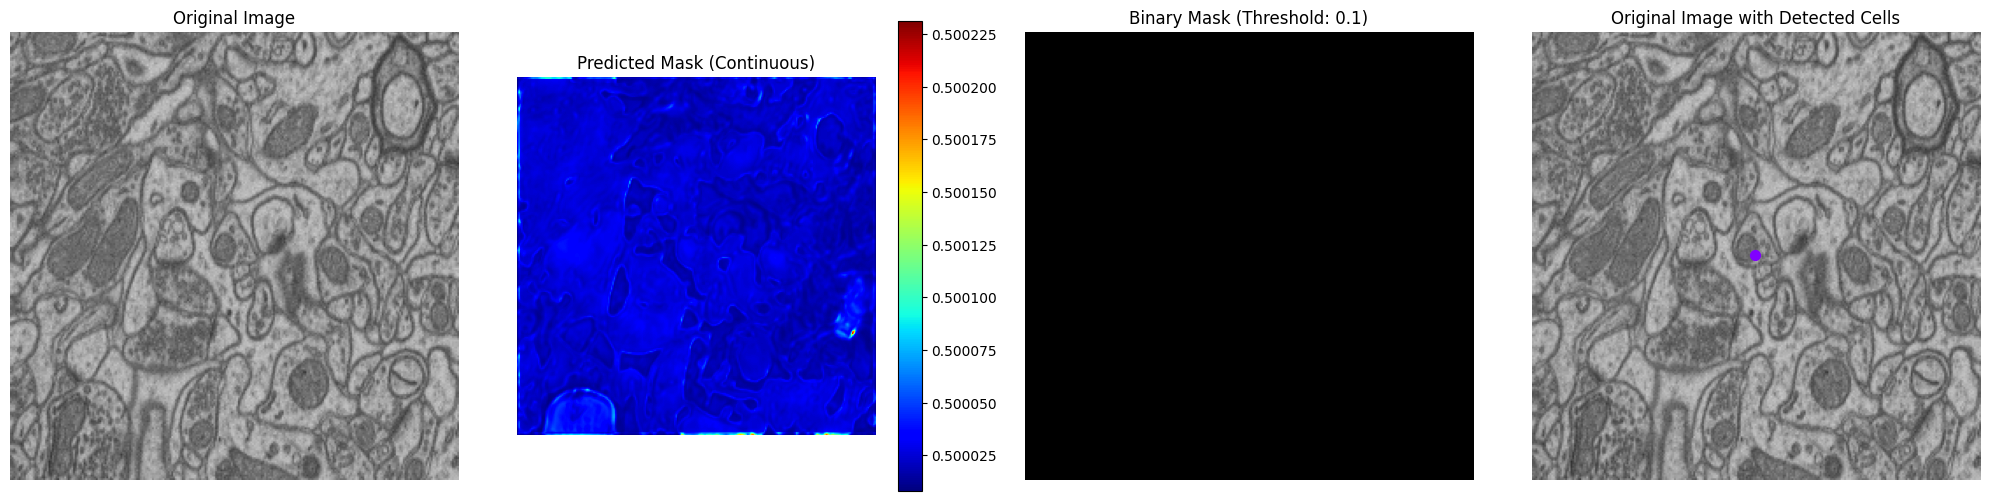

阈值 0.1: 检测到的细胞数量: 1


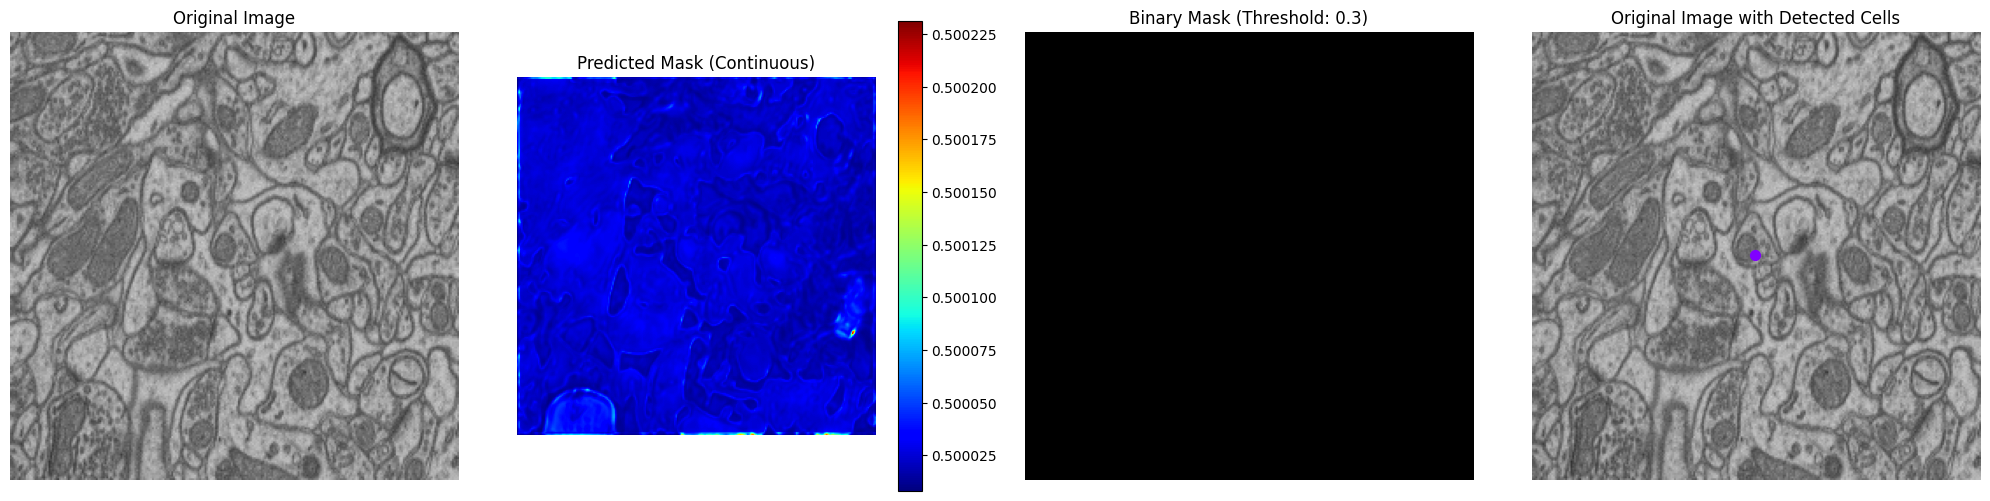

阈值 0.3: 检测到的细胞数量: 1


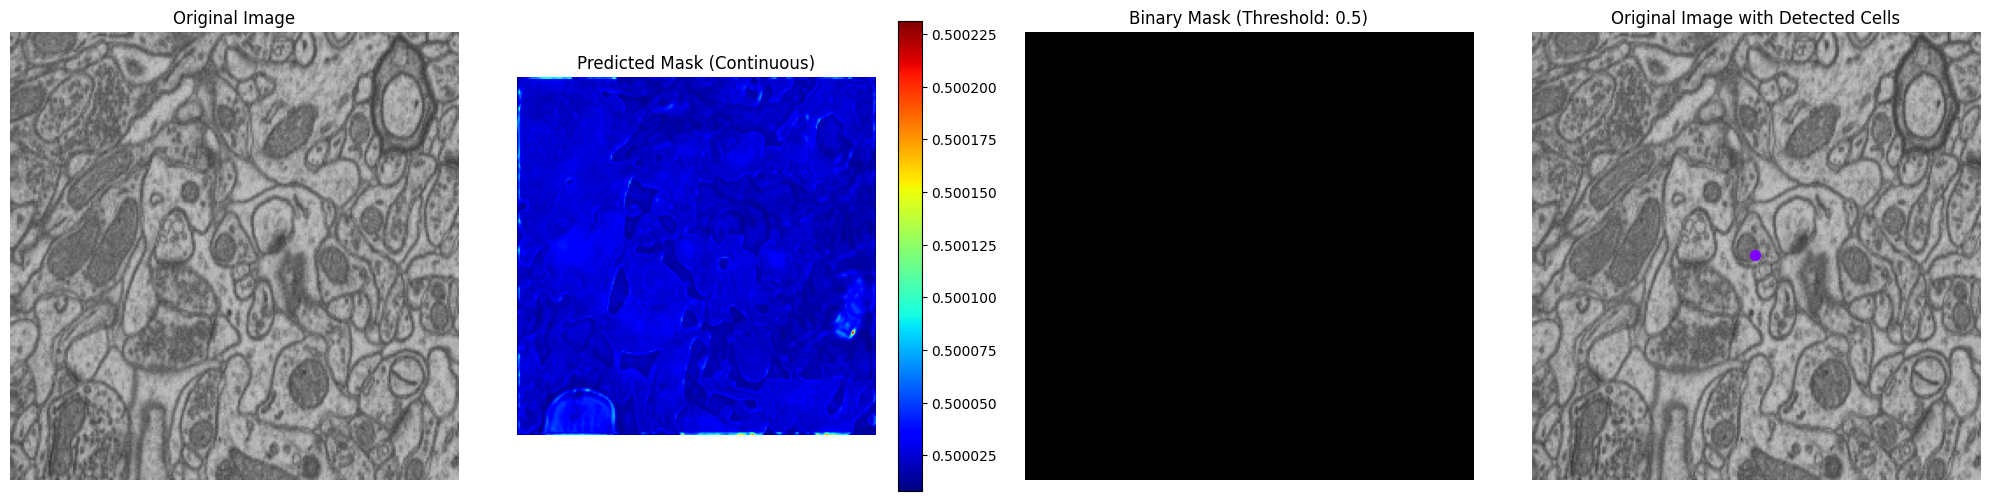

阈值 0.5: 检测到的细胞数量: 1


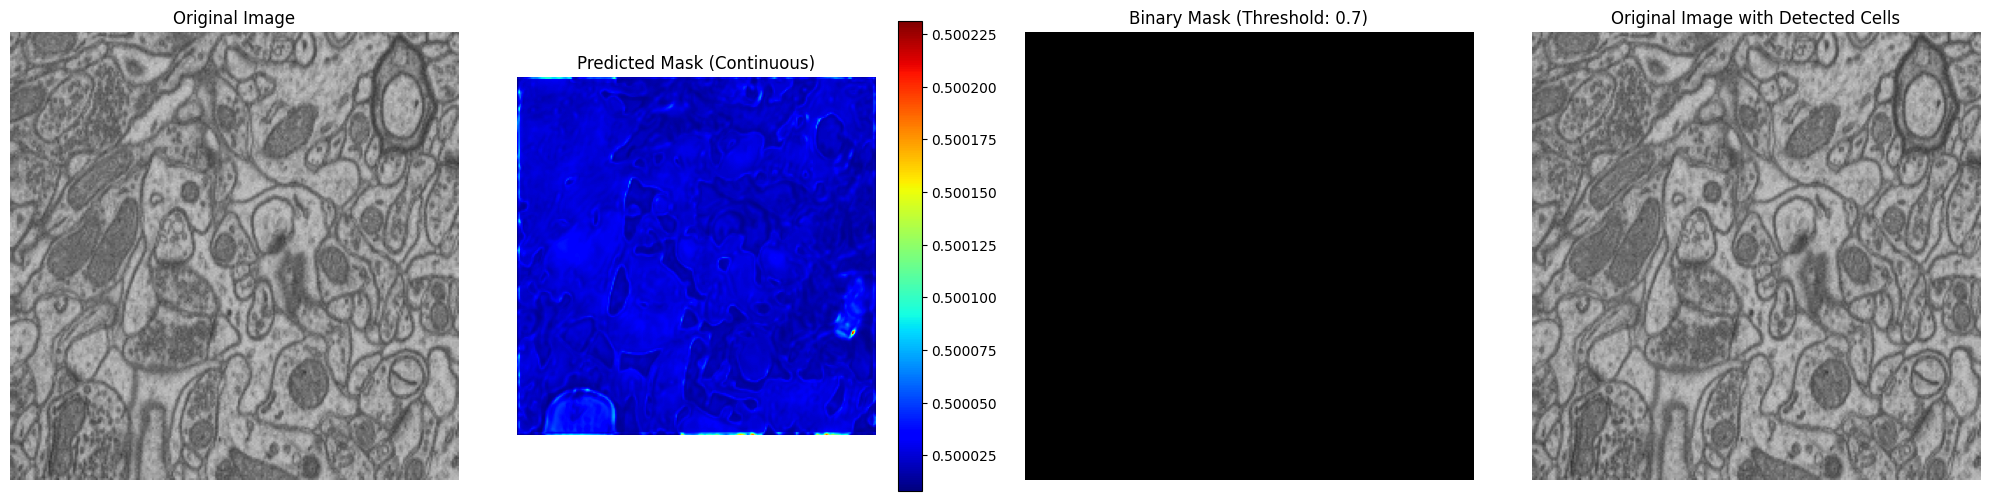

阈值 0.7: 检测到的细胞数量: 0


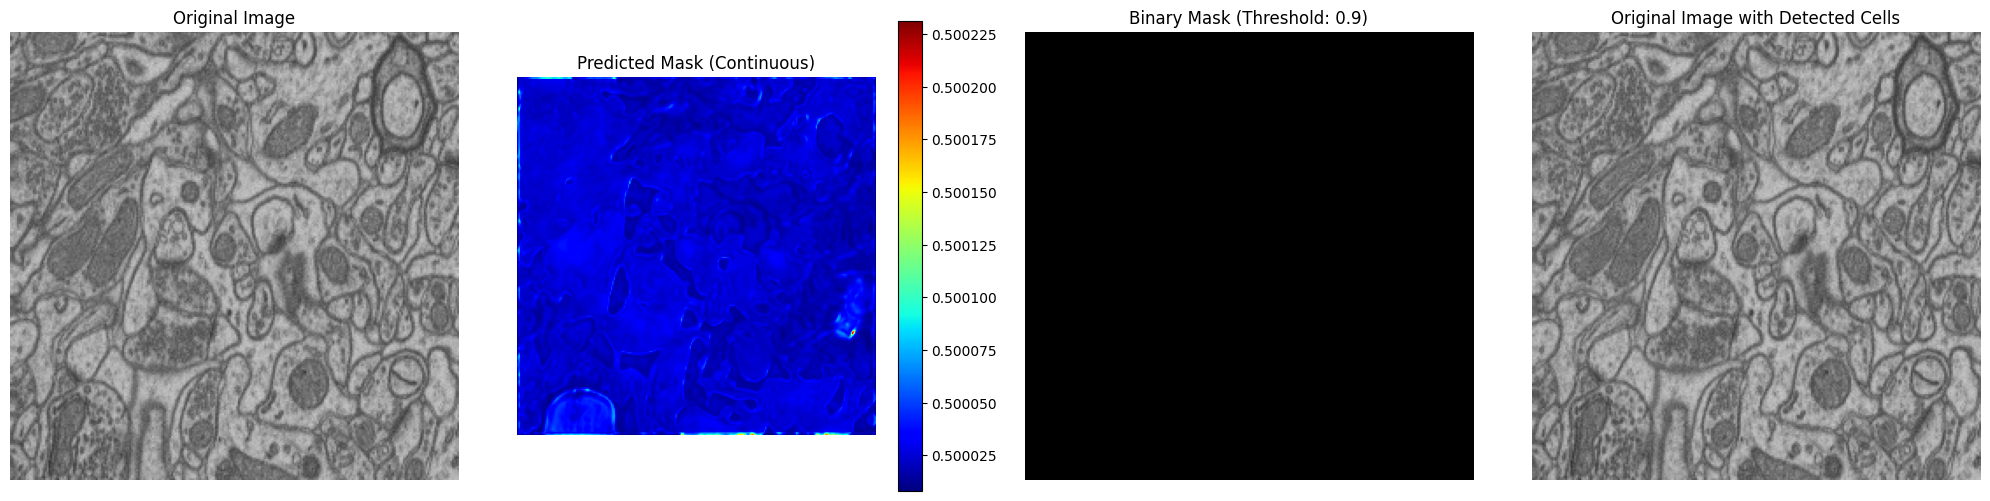

阈值 0.9: 检测到的细胞数量: 0


In [14]:
# 使用示例
image_path = 'mask0000.png'
pred_mask = segment_image(model, image_path, device)

# 打印预测掩码的一些统计信息
print(f"预测掩码的最小值: {pred_mask.min():.4f}")
print(f"预测掩码的最大值: {pred_mask.max():.4f}")
print(f"预测掩码的平均值: {pred_mask.mean():.4f}")

# 尝试不同的阈值
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
for threshold in thresholds:
    binary_mask, points = visualize_segmentation(image_path, pred_mask, threshold)
    print(f"阈值 {threshold}: 检测到的细胞数量: {len(points)}")

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib.colors as mcolors

def process_image(image_path, visualize=True):
    # 读取图像
    image = cv2.imread(image_path)
    if image is None:
        print(f"错误：无法读取图像 {image_path}")
        return None, None, None
    
    # 转换BGR为RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 调整图像大小
    max_size = 1024
    r = min(max_size / image.shape[1], max_size / image.shape[0])
    new_size = (int(image.shape[1] * r), int(image.shape[0] * r))
    image = cv2.resize(image, new_size)
    
    # 预处理图像
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 增加模糊程度
    blurred = cv2.GaussianBlur(gray, (7, 7), 2)
    
    # 使用自适应阈值，调整块大小和C值
    binary = cv2.adaptiveThreshold(
        blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV,
        21,  # 增加块大小
        5    # 增加C值
    )
    
    # 进行更强的形态学操作
    kernel = np.ones((5,5), np.uint8)  # 增加kernel大小
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # 使用连通区域分析
    labels = measure.label(binary)
    regions = measure.regionprops(labels)
    
    # 调整区域过滤条件
    min_area = 200    # 增加最小面积
    max_area = 3000   # 减小最大面积
    min_circularity = 0.6  # 添加圆形度阈值
    
    valid_regions = []
    for region in regions:
        # 计算圆形度
        perimeter = region.perimeter
        area = region.area
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # 根据面积和圆形度进行过滤
        if (min_area < area < max_area and 
            circularity > min_circularity):
            valid_regions.append(region)
    
    # 创建新的二值掩码
    binary_mask = np.zeros_like(binary)
    points = []
    
    for region in valid_regions:
        # 获取区域掩码
        min_row, min_col, max_row, max_col = region.bbox
        mask = region.image
        binary_mask[min_row:max_row, min_col:max_col][mask] = 255
        
        # 获取质心作为点
        y, x = region.centroid
        points.append([int(x), int(y)])
    
    points = np.array(points)
    
    if visualize and len(points) > 0:
        plt.figure(figsize=(20, 5))
        
        # 原始图像
        plt.subplot(1, 4, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')
        
        # 预处理后的图像
        plt.subplot(1, 4, 2)
        plt.title('Preprocessed Image')
        plt.imshow(blurred, cmap='gray')
        plt.axis('off')
        
        # 分割掩码
        plt.subplot(1, 4, 3)
        plt.title('Segmentation Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
        
        # 带标记点的原始图像
        plt.subplot(1, 4, 4)
        plt.title(f'Detected Cells (Count: {len(points)})')
        plt.imshow(image)
        
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], 
                       c=[colors[i % len(colors)]], 
                       s=50)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"检测到的细胞数量: {len(points)}")
    
    return image, binary_mask, points



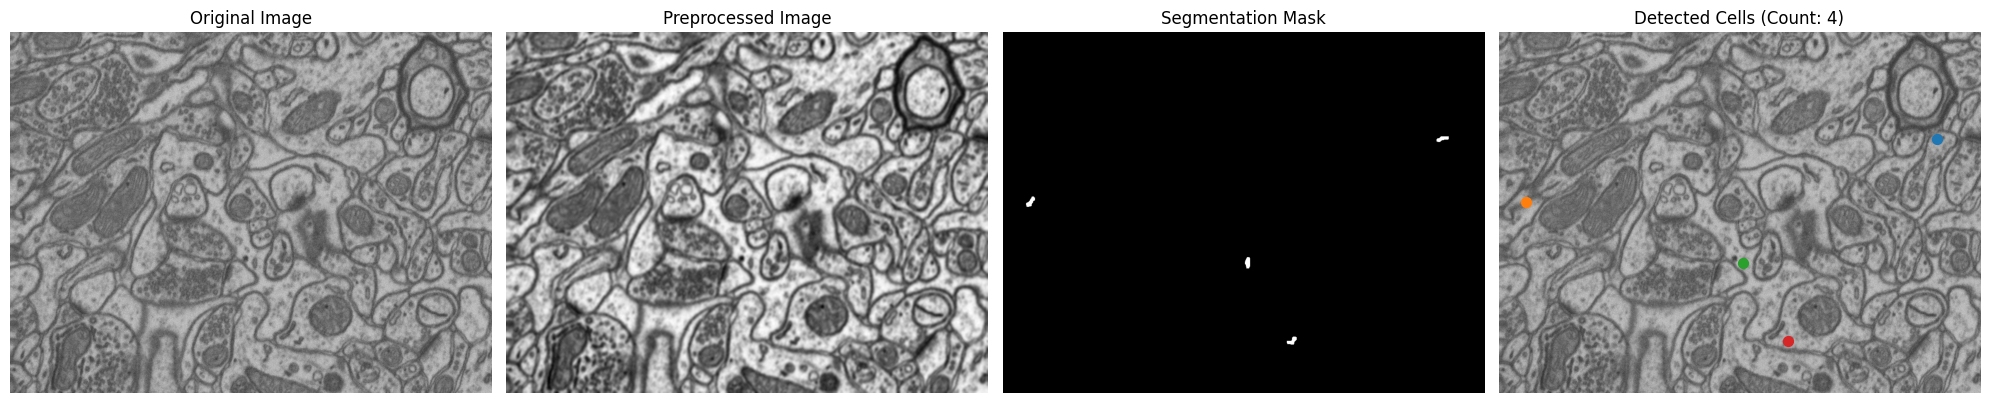

检测到的细胞数量: 4


In [19]:
# 使用示例
image_path = "mask0000.png"
image, mask, points = process_image(image_path, visualize=True)

In [30]:
import torch
torch.cuda.empty_cache()